In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import cv2
import os
import seaborn as sns
sns.set_style('white')

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)


import scipy as sp
from scipy import signal
import dlib
from time import time

In [2]:
def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2
 
    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes)

In [2]:
# decide what is the threshold of binary image that you need

# capture = cv2.VideoCapture("../../../Documents/thermal-project-data/cycling/split/20221014T111320-clip1.MP4")
# net = cv2.dnn.readNetFromCaffe("deploy.prototxt", "res10_300x300_ssd_iter_140000_fp16.caffemodel")
# # get the frame rate
# fps = capture.get(cv2.CAP_PROP_FPS)
# while True:
#     (ret, frame) = capture.read()
#     grayFrame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     (thresh, blackAndWhiteFrame) = cv2.threshold(grayFrame, 127, 255, cv2.THRESH_BINARY_INV)
#     #thresh = cv2.threshold(grayFrame, 127, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    
#     # connected components
#     output = cv2.connectedComponentsWithStats(blackAndWhiteFrame, 4, cv2.CV_32S)
#     (numLabels, labels, stats, centroids) = output
    
#     for i in range(0, numLabels):
#         # if this is the first component then we examine the
#         # *background* (typically we would just ignore this
#         # component in our loop)
# #         if i == 0:
# #             text = "examining component {}/{} (background)".format(i + 1, numLabels)
# #         # otherwise, we are examining an actual connected component
# #         else:
# #             text = "examining component {}/{}".format( i + 1, numLabels)
#         # print a status message update for the current connected
#         # component
#         #print("[INFO] {}".format(text))
#         # extract the connected component statistics and centroid for
#         # the current label
#         x = stats[i, cv2.CC_STAT_LEFT]
#         y = stats[i, cv2.CC_STAT_TOP]
#         w = stats[i, cv2.CC_STAT_WIDTH]
#         h = stats[i, cv2.CC_STAT_HEIGHT]
#         area = stats[i, cv2.CC_STAT_AREA]
#         (cX, cY) = centroids[i]
        
#         keepWidth = w > 5 and w < 50
#         keepHeight = h > 45 and h < 65
#         keepArea = area > 40 and area < 60
    
#         #if keepArea:
#         cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
#         cv2.circle(frame, (int(cX),int(cY)),5,(0,0,255),-1)



#     cv2.imshow('video bw', blackAndWhiteFrame)
#     #cv2.imshow('video bw', thresh)
#     cv2.imshow('frame', frame)
#     key = cv2.waitKey(int((1/fps)*1000))
#     if key == 27 or key == ord('q'):
#         break
# capture.release()
# cv2.destroyAllWindows()

In [11]:
# current work area
capture = cv2.VideoCapture("../../../Documents/thermal-project-data/cycling/20221011T153133.MP4")
net = cv2.dnn.readNetFromCaffe("deploy.prototxt", "res10_300x300_ssd_iter_140000_fp16.caffemodel")
# get the frame rate
fps = capture.get(cv2.CAP_PROP_FPS)
totalFrames = capture.get(cv2.CAP_PROP_FRAME_COUNT)
frameIndex=0
intensityList = []
while True:
    (ret, frame) = capture.read()
    if not ret:
        break;
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0,(300, 300), (104.0, 177.0, 123.0))
    
    # forward pass the caffe model
    net.setInput(blob)
    detections = net.forward()  
    
    # for connected components
    grayFrame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #thresh = cv2.threshold(grayFrame, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    (_, thresh) = cv2.threshold(grayFrame, 127, 255, cv2.THRESH_BINARY_INV)
    # connected components
    output = cv2.connectedComponentsWithStats(thresh, 4, cv2.CV_32S)
    (numLabels, labels, stats, centroids) = output
    
    intsyCurFrame = 0;
    for k in range(1, numLabels):

        xc = stats[k, cv2.CC_STAT_LEFT]
        yc = stats[k, cv2.CC_STAT_TOP]
        wc = stats[k, cv2.CC_STAT_WIDTH]
        hc = stats[k, cv2.CC_STAT_HEIGHT]
        area = stats[k, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[k]

        #print(detections.shape[2])

        #for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with the
        # prediction
        i=0 # by experiment we found that in almost all the case, the first box is the face
        confidence = detections[0, 0, i, 2]
        #print("{} has conf = {}".format(i,confidence))

        # filter out weak detections by ensuring the `confidence` is
        # greater than the minimum confidence
        if confidence > 0.5:
            # compute the (x, y)-coordinates of the bounding box for the
            # object. Object means the face in this case
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # draw the bounding box of the face along with the associated
            # probability
            text = "{:.2f}%".format(confidence * 100)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.rectangle(frame, (startX, startY), (endX, endY),(0, 0, 255), 2)
            cv2.putText(frame, text, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

            #if the centroid of the connecting component is inside the face detected rectangle than show it
            if cX>startX+100 and cX<endX-100:
                if cY>startY+300 and cY<endY-100:
                    cv2.circle(frame, (int(cX),int(cY)),5,(0,0,255),-1)
                    intsyCurFrame+=grayFrame[int(cY),int(cX)]
    
    frameIndex+=1
    intensityList.append(intsyCurFrame)
    cv2.imshow('frame', frame)
    cv2.imshow('bw', thresh)
    key = cv2.waitKey(int((1/fps)*1000))
    if key == 27 or key == ord('q'):
        break
print("Done")

Done


0.033429751738045396
2.0057851042827237


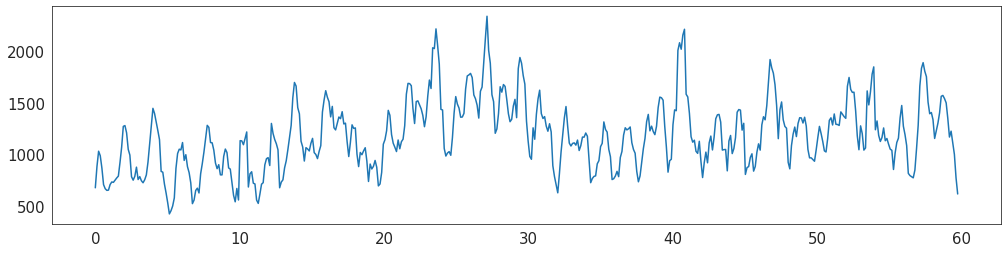

In [36]:
#spolight
size = 5
window = sp.signal.gaussian(M=size, std=5)
window /= window.sum()
filteredA = np.convolve(intensityList, window, mode='same')



fig, ax = plt.subplots(1,1, figsize=(17,4))
ax.plot([i/fps for i in range(0,len(intensityList))], filteredA)
#ax.set_xlim(1,60)
F,A = compute_fft(filteredA, fps)
highestFreq = F[np.argmax(A[1:])+1]
print(highestFreq)
print(highestFreq*60)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


0.03316016359014038
1.9896098154084227


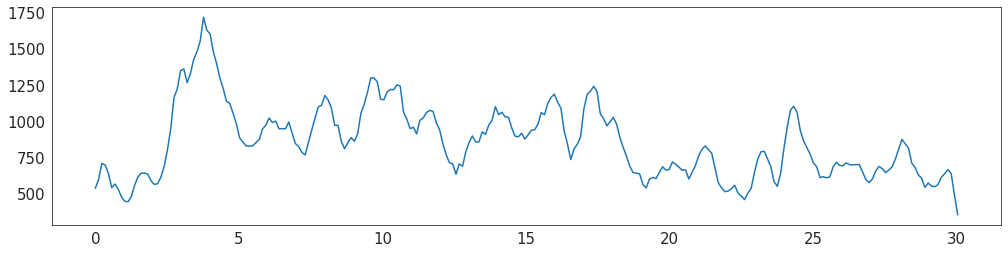

In [4]:

size = 5
window = sp.signal.gaussian(M=size, std=5)
window /= window.sum()
filteredA = np.convolve(intensityList, window, mode='same')



fig, ax = plt.subplots(1,1, figsize=(17,4))
ax.plot([i/fps for i in range(0,len(intensityList))], filteredA)
#ax.set_xlim(1,60)
F,A = compute_fft(filteredA, fps)
highestFreq = F[np.argmax(A[1:])+1]
print(highestFreq)
print(highestFreq*60)

0.631806467703051
37.908388062183064


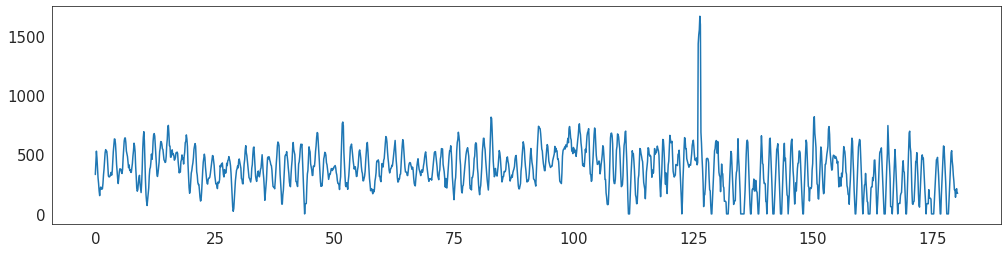

In [7]:
# 20221011T153133.MP4 P5_3
size = 5
window = sp.signal.gaussian(M=size, std=5)
window /= window.sum()
filteredA = np.convolve(intensityList, window, mode='same')



fig, ax = plt.subplots(1,1, figsize=(17,4))
ax.plot([i/fps for i in range(0,len(intensityList))], filteredA)
#ax.set_xlim(1,60)
F,A = compute_fft(filteredA, fps)
highestFreq = F[np.argmax(A[1:])+1]
print(highestFreq)
print(highestFreq*60)

0.005539194416492029
0.33235166498952173


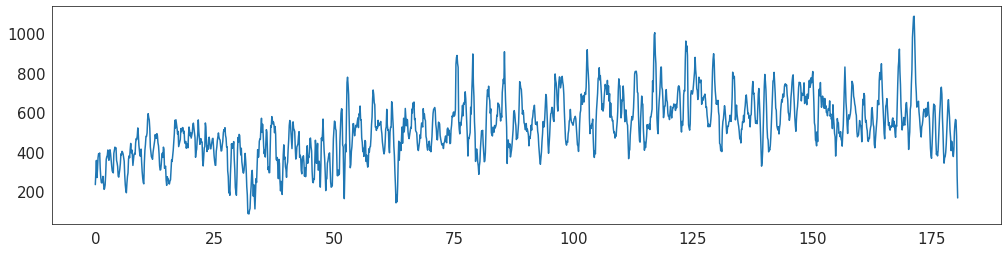

In [9]:
# 20221011T153501.MP4 P5_4
size = 5
window = sp.signal.gaussian(M=size, std=5)
window /= window.sum()
filteredA = np.convolve(intensityList, window, mode='same')



fig, ax = plt.subplots(1,1, figsize=(17,4))
ax.plot([i/fps for i in range(0,len(intensityList))], filteredA)
#ax.set_xlim(1,60)
F,A = compute_fft(filteredA, fps)
highestFreq = F[np.argmax(A[1:])+1]
print(highestFreq)
print(highestFreq*60)

In [8]:
# # load our serialized model from disk
# print("[INFO] loading model...")
# net = cv2.dnn.readNetFromCaffe("deploy.prototxt", "res10_300x300_ssd_iter_140000_fp16.caffemodel")

# #capture = cv2.VideoCapture("../../../Documents/thermal-project-data/cycling/split/20221014T111320-clip3.MP4")
# #(ret, frame) = capture.read()

# frame = cv2.imread('../../../Documents/thermal-project-data/demo-images-pips/P11/1/10.jpg')
# #frame = cv2.imread('caffee.jpg')

# (h, w) = frame.shape[:2]
# blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0,(300, 300), (104.0, 177.0, 123.0))
 
# print("[INFO] computing object detections...")
# net.setInput(blob)
# detections = net.forward()   
                           
# for i in range(0, detections.shape[2]):
#     # extract the confidence (i.e., probability) associated with the
#     # prediction
#     confidence = detections[0, 0, i, 2]
    
#     # filter out weak detections by ensuring the `confidence` is
#     # greater than the minimum confidence
#     if confidence > 0.5:
#         # compute the (x, y)-coordinates of the bounding box for the
#         # object
#         box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
#         (startX, startY, endX, endY) = box.astype("int")

#         # draw the bounding box of the face along with the associated
#         # probability
#         text = "{:.2f}%".format(confidence * 100)
#         y = startY - 10 if startY - 10 > 10 else startY + 10
#         cv2.rectangle(frame, (startX, startY), (endX, endY),
#             (0, 0, 255), 2)
#         cv2.putText(frame, text, (startX, y),
#             cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)                           
                           
# cv2.imshow('frame', frame)
# cv2.waitKey(0)
                           
                           
        